#**The impact of ENSO on precipitation and temperature**

**Content creators:** Olawale Ikuyajolu & Patrick Orenstein

**Content reviewers:** Marguerite Brown, Yuxin Zhou

**Content editors:** Zane Mitrevica, Natalie Steinemann

**Production editors:** TBD

**Our 2023 Sponsors:** TBD

In [ ]:
# @title #**Project background** 
#This will be a short video introducing the content creator(s) and motivating the research direction of the template.
#The Tech team will add code to format and display the video

#Title: ENSO impact on precipitation & temperature

To understand the historical and future impacts of El Niño Southern Oscillation (ENSO) events on rainfall and temperature, you will work with climate model output, reanalysis data, and Niño 3.4 indices from CMIP5/6, ERA5, NOAA, and HadISST, focusing on variables like sea surface temperature, surface air temperature, and precipitation. You will also be able to investigate the relationships between these variables and how they affect community efforts to prepare for the impacts of El Niño phases.


#**Project template**
<p align='center'><a href="https://github.com/ClimatematchAcademy/course-content/tree/main/projects/template_images/ENSO_template_map.svg"><img src="https://github.com/ClimatematchAcademy/course-content/tree/main/projects/template_images/ENSO_template_map.svg" alt="The impact of ENSO on precipitation and temperature" vw="100" vh="75" /></a></p>

#**Data exploration notebook**
##**Project setup**



Please run the following cells!
    



In [ ]:
#Imports
#Reload again if failed

!pip install condacolab &> /dev/null        
import condacolab
condacolab.install()

# Install all packages in one call (+ use mamba instead of conda)
# hopefully this improves speed
!mamba install xarray-datatree intake-esm gcsfs xmip aiohttp cartopy nc-time-axis cf_xarray xarrayutils "esmf<=8.3.1" xesmf &> /dev/null
# For xesmf install we need to pin "esmf<=8.3.1". More context here: https://github.com/pangeo-data/xESMF/issues/246

import time
tic = time.time()

import intake
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe

from xmip.preprocessing import combined_preprocessing
from xarrayutils.plotting import shaded_line_plot

from datatree import DataTree
from xmip.postprocessing import _parse_metric

import cartopy.crs as ccrs

^C
⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:18
🔁 Restarting kernel...


ImportError: ignored

In [ ]:
# Functions

col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json") # open an intake catalog containing the Pangeo CMIP cloud data

def load_cmip6(source_id, variable_id, member_id, table_id ):
  cat = col.search(
    source_id=source_ids,
    variable_id= variable_id,
    member_id=member_id,
    table_id=table_id,
    grid_label='gn',
    experiment_id = ['historical', 'ssp585'],
    require_all_on = ['source_id']
  )

  kwargs = dict(
    preprocess=combined_preprocessing,
    xarray_open_kwargs=dict(use_cftime=True),
    storage_options={'token':'anon'}
   ) 
  cat.esmcat.aggregation_control.groupby_attrs = ['source_id', 'experiment_id']
  dt = cat.to_datatree(**kwargs)

  return dt

##**Dataset 1: Load CMIP6 Model of your choice**

Following W2D1 (Week 2 Day 1) tutorial notebook

  * We use *r4i1p1f1 and CESM2* as the template, but you are free to select any model. Make sure the member_id selected is available for your model
  
  * load_cmip6 function load both historical and ssp585 (future: climate change) 




In [ ]:
# pick your model
#reload again if failed
source_ids = 'CESM2'

dm_tas = load_cmip6(source_ids, 'tas', 'r4i1p1f1', 'Amon' )
dm_pr = load_cmip6(source_ids, 'pr', 'r4i1p1f1', 'Amon' )
dm_sst = load_cmip6(source_ids, 'tos', 'r4i1p1f1', 'Omon' )


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


In [ ]:
#Load cell areas for computing means

cat_ocean_area = col.search(
    source_id=source_ids,
    variable_id='areacello',
    member_id='r4i1p1f1', #
    table_id='Ofx',
    grid_label='gn',
    experiment_id = ['historical'],
    require_all_on = ['source_id']
)
kwargs = dict(
    preprocess=combined_preprocessing,
    xarray_open_kwargs=dict(use_cftime=True),
    storage_options={'token':'anon'}
   ) 

cat_ocean_area.esmcat.aggregation_control.groupby_attrs = ['source_id', 'experiment_id']
dt_ocean_area = cat_ocean_area.to_datatree(**kwargs)

cat_atmos_area = col.search(
    source_id=source_ids,
    variable_id='areacella',
    member_id='r4i1p1f1', #
    table_id='fx',
    grid_label='gn',
    experiment_id = ['historical'],
    require_all_on = ['source_id']
)

cat_atmos_area.esmcat.aggregation_control.groupby_attrs = ['source_id', 'experiment_id']
dt_atmos_area = cat_atmos_area.to_datatree(**kwargs)

dt_ocean_with_area = DataTree()
dt_atmos_with_area = DataTree()

for model,subtree in dm_sst.items():
    metric_ocean = dt_ocean_area[model]['historical'].ds['areacello']
    dt_ocean_with_area[model] = subtree.map_over_subtree(_parse_metric,metric_ocean)

for model,subtree in dm_pr.items():
    metric_atmos = dt_atmos_area[model]['historical'].ds['areacella']
    dt_atmos_with_area[model] = subtree.map_over_subtree(_parse_metric,metric_atmos)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


##**Dataset 2: Load Observations**

First we load a dataset. We will use the NOAA Extended Reconstructed Sea Surface Temperature (ERSST) v5 product, a widely used and trusted gridded compilation of of historical data going back to 1854.Since the data is provided via an OPeNDAP server, we can load it directly without downloading anything

CPC Merged Analysis of Precipitation (CMAP) for precipitation. We download this dataset from NOAA PSL, Boulder, Colorado, USA website at https://psl.noaa.gov

For air temperature, we are using anomalies from NASA GISS Surface Temperature Analysis. Also from from NOAA PSL, Boulder, Colorado, USA website at https://psl.noaa.gov


In [ ]:
#SST
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
do_sst = xr.open_dataset(url, drop_variables=['time_bnds'])

#Precipitation
!wget https://downloads.psl.noaa.gov/Datasets/cmap/enh/precip.mon.mean.nc
do_pr = xr.open_dataset('precip.mon.mean.nc')

#Air Temperature Anomalies
!wget https://downloads.psl.noaa.gov/Datasets/gistemp/combined/1200km/air.2x2.1200.mon.anom.comb.nc
do_tas = xr.open_dataset('air.2x2.1200.mon.anom.comb.nc')

--2023-05-09 00:18:09--  https://downloads.psl.noaa.gov/Datasets/cmap/enh/precip.mon.mean.nc
Resolving downloads.psl.noaa.gov (downloads.psl.noaa.gov)... 140.172.38.86
Connecting to downloads.psl.noaa.gov (downloads.psl.noaa.gov)|140.172.38.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15654694 (15M) [application/x-netcdf]
Saving to: ‘precip.mon.mean.nc’

precip.mon.mean.nc  100%[===================>]  14.93M  35.4MB/s    in 0.4s    

2023-05-09 00:18:10 (35.4 MB/s) - ‘precip.mon.mean.nc’ saved [15654694/15654694]

--2023-05-09 00:18:10--  https://downloads.psl.noaa.gov/Datasets/gistemp/combined/1200km/air.2x2.1200.mon.anom.comb.nc
Resolving downloads.psl.noaa.gov (downloads.psl.noaa.gov)... 140.172.38.86
Connecting to downloads.psl.noaa.gov (downloads.psl.noaa.gov)|140.172.38.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256804575 (245M) [application/x-netcdf]
Saving to: ‘air.2x2.1200.mon.anom.comb.nc’

air.2x2.1200.mon.an 

We can now visualize the content of the dataset.



/usr/local/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


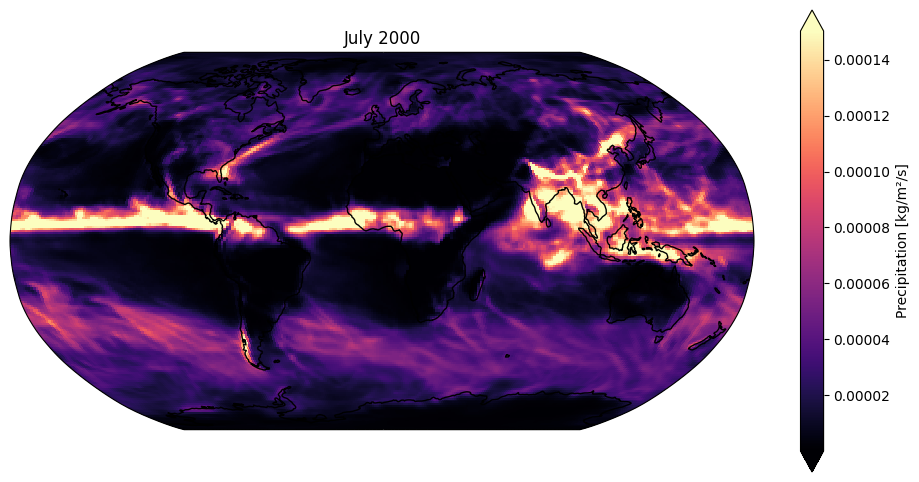

In [ ]:
# Code to print the shape, array names, etc of the dataset

%matplotlib inline

# select just a single model and experiment
hist_precip = dm_pr['CESM2']['historical'].ds.pr


fig, (ax_july2000) = plt.subplots(
    ncols=1, nrows=1,
    figsize=[12,6],
    subplot_kw={'projection':ccrs.Robinson()}
)

# plot a timestep for 2000
sst_July2000 = hist_precip.sel(time='2000-07').squeeze()
sst_July2000.plot(ax=ax_july2000, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap='magma', robust=True)
ax_july2000.coastlines()
ax_july2000.set_title('July 2000')



plt.show()

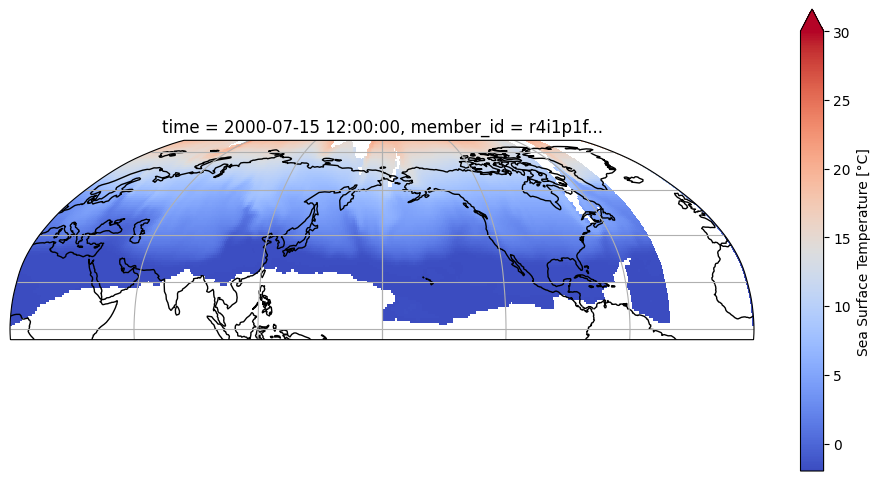

In [ ]:
hist_sst = dm_sst['CESM2']['historical'].ds.tos

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.coastlines()
ax.gridlines()
hist_sst.sel(time='2000-07').squeeze().plot(
    ax=ax, transform=ccrs.PlateCarree(), vmin=-2, vmax=30, cmap='coolwarm'
);

In [ ]:
hist_sst

<xarray.DataArray 'tos' (member_id: 1, dcpp_init_year: 1, time: 1980, y: 384,
                         x: 320)>
dask.array<broadcast_to, shape=(1, 1, 1980, 384, 320), dtype=float32, chunksize=(1, 1, 403, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    lat             (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon             (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time            (time) object 1850-01-15 12:59:59.999997 ... 2014-12-15 1...
  * y               (y) int64 0 1 2 3 4 5 6 7 ... 377 378 379 380 381 382 383
  * x               (x) int64 0 1 2 3 4 5 6 7 ... 313 314 315 316 317 318 319
  * member_id       (member_id) object 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Attributes: (12/19)
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        This may differ from "surface temperature" in regions of ...
    description:    This may differ from "surface temperature" in regions of ...
    frequency:      mon
    id:             tos
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Surface Temperature
    type:           real
    variable_id:    tos
    units:          °C

## **Dataset 3: Nino 3.4 Index : need to get from IRI or NOAA PSL**

In [ ]:
url = 'http://iridl.ldeo.columbia.edu/SOURCES/.Indices/.nino/.NCEP/.NINO34/dods'
nino34 = xr.open_dataset(url, decode_times=False)

Now that you have loaded and visualized the data, we are all set to find and answer a meaningful research question!

#**Further reading**

Still missing